In [79]:
# 1. Load packages & libraries

# Step 1.1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Step 1.2: Load the data with Latin-1 encoding (same as your R script)
superstore = pd.read_csv('data/superstore.csv', encoding='latin-1')

# Step 1.3: Clean column names (like janitor::clean_names())
superstore.columns = (superstore.columns
                      .str.strip()
                      .str.lower()
                      .str.replace(' ', '_')
                      .str.replace('-', '_'))

print("Data loaded successfully with Latin-1 encoding!")
print(f"Dataset shape: {superstore.shape}")
print(f"Columns: {list(superstore.columns)}")
print("\nFirst 3 rows:")
superstore.head(3)

Data loaded successfully with Latin-1 encoding!
Dataset shape: (9994, 21)
Columns: ['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode', 'customer_id', 'customer_name', 'segment', 'country', 'city', 'state', 'postal_code', 'region', 'product_id', 'category', 'sub_category', 'product_name', 'sales', 'quantity', 'discount', 'profit']

First 3 rows:


,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,postal_code,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [80]:
# 2. Data Cleaning
# Step 2.1: Create a copy of the dataframe
df = superstore.copy()

# Step 2.2: Convert order_date with multiple formats (same as your R script)
df['order_date'] = pd.to_datetime(df['order_date'], format='mixed', dayfirst=False)

# Step 2.3: Filter out rows with missing critical values
df = df.dropna(subset=['customer_id', 'order_date', 'sales'])

print("Data cleaning completed!")
print(f"Shape after cleaning: {df.shape}")
print(f"Date range: {df['order_date'].min()} to {df['order_date'].max()}")
print(f"Missing values check:")
print(f"  - customer_id: {df['customer_id'].isna().sum()}")
print(f"  - order_date: {df['order_date'].isna().sum()}")
print(f"  - sales: {df['sales'].isna().sum()}")

# Show first few rows to verify date conversion
df[['customer_id', 'order_date', 'sales']].head(3)

Data cleaning completed!
Shape after cleaning: (9994, 21)
Date range: 2014-01-03 00:00:00 to 2017-12-30 00:00:00
Missing values check:
  - customer_id: 0
  - order_date: 0
  - sales: 0


,customer_id,order_date,sales
0,CG-12520,2016-11-08,261.96
1,CG-12520,2016-11-08,731.94
2,DV-13045,2016-06-12,14.62


In [81]:
# 3. RFM Compute
# Step 3.1: Calculate analysis date (max order date + 1 day)
analysis_date = df['order_date'].max() + pd.Timedelta(days=1)
print(f"Analysis date: {analysis_date}")

# Step 3.2: Compute RFM metrics
rfm_data = df.groupby(['customer_id', 'customer_name']).agg(
    recency_days=('order_date', lambda x: (analysis_date - x.max()).days),
    frequency=('order_id', 'nunique'),
    monetary=('sales', 'sum')
).reset_index()

print("RFM computation completed!")
print(f"RFM data shape: {rfm_data.shape}")
print(f"Unique customers: {len(rfm_data)}")

# Step 3.3: Display summary statistics to match your R results
print("\nSummary statistics:")
print(f"Recency days - Min: {rfm_data['recency_days'].min()}, Max: {rfm_data['recency_days'].max()}")
print(f"Frequency - Min: {rfm_data['frequency'].min()}, Max: {rfm_data['frequency'].max()}")
print(f"Monetary - Min: {rfm_data['monetary'].min():.2f}, Max: {rfm_data['monetary'].max():.2f}")

# Show first few rows
print("\nFirst 6 rows of RFM data:")
rfm_data.head(6)

Analysis date: 2017-12-31 00:00:00
RFM computation completed!
RFM data shape: (793, 5)
Unique customers: 793

Summary statistics:
Recency days - Min: 1, Max: 1166
Frequency - Min: 1, Max: 17
Monetary - Min: 4.83, Max: 25043.05

First 6 rows of RFM data:


,customer_id,customer_name,recency_days,frequency,monetary
0,AA-10315,Alex Avila,185,5,5563.560
1,AA-10375,Allen Armold,20,9,1056.390
2,AA-10480,Andrew Allen,260,4,1790.512
3,AA-10645,Anna Andreadi,56,6,5086.935
4,AB-10015,Aaron Bergman,416,3,886.156
5,AB-10060,Adam Bellavance,55,8,7755.620


In [86]:
# 4. RFM Scores Assignments
# Step 4.1 (Final Fix): Exact replication of R's ntile behavior
def r_ntile(values, n):
    """Replicates R's ntile function exactly"""
    # Rank the values, using 'first' method to break ties like R
    ranks = values.rank(method='first')
    # Calculate the size of each tile
    tile_size = len(values) / n
    # Assign tiles
    tiles = np.ceil(ranks / tile_size).astype(int)
    return tiles

# Apply R's ntile logic exactly
rfm_data['R_score'] = r_ntile(-rfm_data['recency_days'], 5)  # smaller recency = higher score
rfm_data['F_score'] = r_ntile(rfm_data['frequency'], 5)
rfm_data['M_score'] = r_ntile(rfm_data['monetary'], 5)

# Recalculate RFM total score
rfm_data['RFM_Score'] = rfm_data['R_score'] + rfm_data['F_score'] + rfm_data['M_score']

# Reapply segmentation
rfm_data['Segment'] = rfm_data['RFM_Score'].apply(assign_segment)

print("Final fix with exact R ntile replication!")
print("\nFinal score distributions:")
print(f"R_score: {rfm_data['R_score'].value_counts().sort_index().to_dict()}")
print(f"F_score: {rfm_data['F_score'].value_counts().sort_index().to_dict()}")
print(f"M_score: {rfm_data['M_score'].value_counts().sort_index().to_dict()}")

print("\nFinal segment distribution:")
final_segment_counts = rfm_data['Segment'].value_counts()
print(final_segment_counts)

print("\nRFM Score distribution:")
print(rfm_data['RFM_Score'].value_counts().sort_index())

print("\nExpected from your R:")
print("At Risk: 39")
print("Champions: 121") 
print("Loyal Customers: 256")
print("Needs Attention: 159")
print("Potential Loyalists: 218")

Final fix with exact R ntile replication!

Final score distributions:
R_score: {1: 158, 2: 159, 3: 158, 4: 159, 5: 159}
F_score: {1: 158, 2: 159, 3: 158, 4: 159, 5: 159}
M_score: {1: 158, 2: 159, 3: 158, 4: 159, 5: 159}

Final segment distribution:
Segment
Loyal Customers        256
Potential Loyalists    216
Needs Attention        158
Champions              124
At Risk                 39
Name: count, dtype: int64

RFM Score distribution:
RFM_Score
3     39
4     39
5     58
6     61
7     77
8     62
9     77
10    92
11    98
12    66
13    62
14    40
15    22
Name: count, dtype: int64

Expected from your R:
At Risk: 39
Champions: 121
Loyal Customers: 256
Needs Attention: 159
Potential Loyalists: 218


In [87]:
# 5. Customers Segmentations
# Step 5.1: Create segmentation based on RFM scores
def assign_segment(rfm_score):
    if rfm_score >= 13:
        return "Champions"
    elif rfm_score >= 10:
        return "Loyal Customers"
    elif rfm_score >= 7:
        return "Potential Loyalists"
    elif rfm_score >= 4:
        return "Needs Attention"
    else:
        return "At Risk"

# Apply segmentation
rfm_data['Segment'] = rfm_data['RFM_Score'].apply(assign_segment)

print("Customer segmentation completed!")
print("\nSegment distribution:")
segment_counts = rfm_data['Segment'].value_counts()
print(segment_counts)

# Step 5.2: Verify this matches your R results
print("\nExpected from your R:")
print("At Risk: 39")
print("Champions: 121") 
print("Loyal Customers: 256")
print("Needs Attention: 159")
print("Potential Loyalists: 218")

# Show RFM score distribution
print(f"\nRFM Score distribution:")
print(rfm_data['RFM_Score'].value_counts().sort_index())

# Show first few rows with segments
print("\nFirst 6 rows with segments:")
rfm_data[['customer_id', 'customer_name', 'RFM_Score', 'Segment']].head(6)

Customer segmentation completed!

Segment distribution:
Segment
Loyal Customers        256
Potential Loyalists    216
Needs Attention        158
Champions              124
At Risk                 39
Name: count, dtype: int64

Expected from your R:
At Risk: 39
Champions: 121
Loyal Customers: 256
Needs Attention: 159
Potential Loyalists: 218

RFM Score distribution:
RFM_Score
3     39
4     39
5     58
6     61
7     77
8     62
9     77
10    92
11    98
12    66
13    62
14    40
15    22
Name: count, dtype: int64

First 6 rows with segments:


,customer_id,customer_name,RFM_Score,Segment
0,AA-10315,Alex Avila,9,Potential Loyalists
1,AA-10375,Allen Armold,12,Loyal Customers
2,AA-10480,Andrew Allen,5,Needs Attention
3,AA-10645,Anna Andreadi,11,Loyal Customers
4,AB-10015,Aaron Bergman,3,At Risk
5,AB-10060,Adam Bellavance,12,Loyal Customers


In [84]:
# Let's check the exact RFM score ranges for each segment in our data
print("RFM Score ranges by segment:")
segment_ranges = rfm_data.groupby('Segment')['RFM_Score'].agg(['min', 'max']).sort_values('min', ascending=False)
print(segment_ranges)

print("\nDetailed count by RFM_Score and Segment:")
score_segment_counts = rfm_data.groupby(['RFM_Score', 'Segment']).size().reset_index(name='count')
print(score_segment_counts.sort_values('RFM_Score'))

# Compare with your R segmentation logic
print("\n--- Your R Segmentation Logic ---")
print("Champions: RFM_Score >= 13")
print("Loyal Customers: RFM_Score >= 10") 
print("Potential Loyalists: RFM_Score >= 7")
print("Needs Attention: RFM_Score >= 4")
print("At Risk: RFM_Score < 4")

# Let's manually verify the counts using your exact logic
champions = rfm_data[rfm_data['RFM_Score'] >= 13]
loyal = rfm_data[(rfm_data['RFM_Score'] >= 10) & (rfm_data['RFM_Score'] <= 12)]
potential = rfm_data[(rfm_data['RFM_Score'] >= 7) & (rfm_data['RFM_Score'] <= 9)]
needs_attention = rfm_data[(rfm_data['RFM_Score'] >= 4) & (rfm_data['RFM_Score'] <= 6)]
at_risk = rfm_data[rfm_data['RFM_Score'] < 4]

print(f"\nManual verification using your R logic:")
print(f"Champions (>=13): {len(champions)}")
print(f"Loyal Customers (10-12): {len(loyal)}")
print(f"Potential Loyalists (7-9): {len(potential)}")
print(f"Needs Attention (4-6): {len(needs_attention)}")
print(f"At Risk (<4): {len(at_risk)}")

RFM Score ranges by segment:
                     min  max
Segment                      
Champions             13   15
Loyal Customers       10   12
Potential Loyalists    7    9
Needs Attention        4    6
At Risk                3    3

Detailed count by RFM_Score and Segment:
    RFM_Score              Segment  count
0           3              At Risk     45
1           4      Needs Attention     38
2           5      Needs Attention     64
3           6      Needs Attention     63
4           7  Potential Loyalists     74
5           8  Potential Loyalists     68
6           9  Potential Loyalists     81
7          10      Loyal Customers     98
8          11      Loyal Customers     82
9          12      Loyal Customers     69
10         13            Champions     56
11         14            Champions     33
12         15            Champions     22

--- Your R Segmentation Logic ---
Champions: RFM_Score >= 13
Loyal Customers: RFM_Score >= 10
Potential Loyalists: RFM_Score >= 7


In [88]:
# 6. Segments Summary
# Step 6.1: Create segment summary (same as your R)
segment_summary = rfm_data.groupby('Segment').agg(
    Customers=('customer_id', 'count'),
    Avg_Recency=('recency_days', lambda x: round(x.mean(), 1)),
    Avg_Frequency=('frequency', lambda x: round(x.mean(), 1)),
    Avg_Monetary=('monetary', lambda x: round(x.mean(), 2))
).reset_index()

print("Segment summary completed!")
print("\nSegment Summary:")
print(segment_summary)

# Step 6.2: Verify this matches your R summary
print("\nYour R segment_summary should be similar to this")

Segment summary completed!

Segment Summary:
               Segment  Customers  Avg_Recency  Avg_Frequency  Avg_Monetary
0              At Risk         39        503.0            2.5        396.99
1            Champions        124         28.1            9.4       5221.25
2      Loyal Customers        256         75.0            7.4       3851.34
3      Needs Attention        158        284.7            4.0       1133.35
4  Potential Loyalists        216        138.6            5.6       2172.55

Your R segment_summary should be similar to this


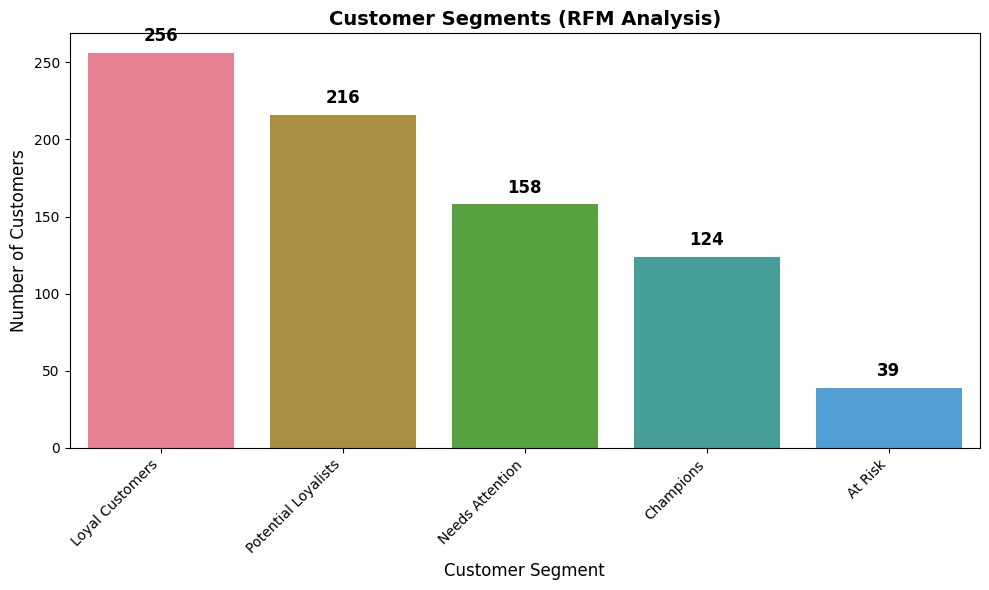

In [102]:
# 7. Segment Summary visuals
# Step 7.1: Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# # Step 7.2: Create bar plot with custom segment order
custom_order = ['Loyal Customers', 'Potential Loyalists', 'Needs Attention', 'Champions', 'At Risk']

# Reorder the segment_summary dataframe
segment_summary_ordered = segment_summary.set_index('Segment').loc[custom_order].reset_index()

plt.figure(figsize=(10, 6))
rfm_plot = sns.barplot(data=segment_summary_ordered, x='Segment', y='Customers', hue='Segment', legend=False,
                       order=custom_order)

# Add numbers above bars
for i, count in enumerate(segment_summary_ordered['Customers']):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', size=12, fontweight='bold')

plt.title('Customer Segments (RFM Analysis)', fontsize=14, fontweight='bold')
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

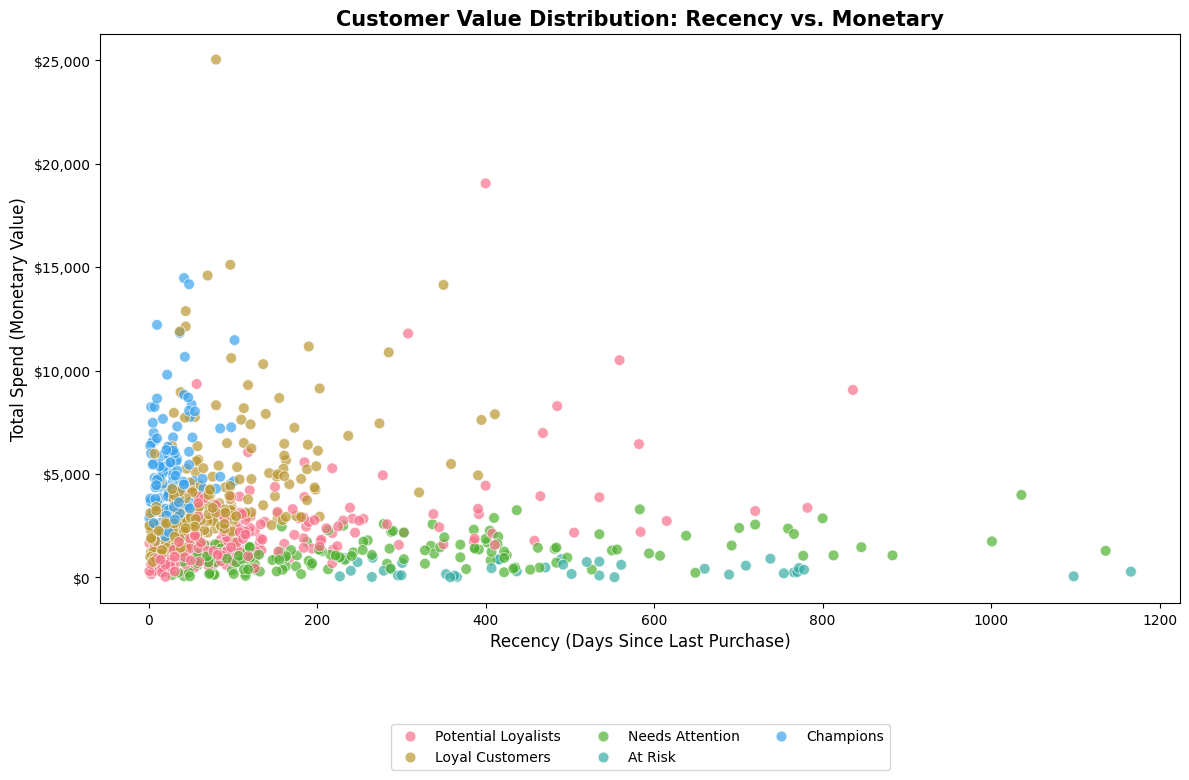

Scatter plot created successfully!


In [91]:
# Step 7.3: Create scatter plot - Recency vs Monetary colored by Segment
plt.figure(figsize=(12, 8))
rfm_scatter = sns.scatterplot(
    data=rfm_data,
    x='recency_days',
    y='monetary',
    hue='Segment',
    alpha=0.7,
    s=60  # point size
)

plt.title('Customer Value Distribution: Recency vs. Monetary', fontsize=15, fontweight='bold')
plt.xlabel('Recency (Days Since Last Purchase)', fontsize=12)
plt.ylabel('Total Spend (Monetary Value)', fontsize=12)

# Format y-axis as currency
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3)
plt.tight_layout()
plt.show()

print("Scatter plot created successfully!")

In [92]:
import os

def show_folder_structure(startpath='.', max_depth=3):
    """Display the folder structure"""
    print("Current Project Structure:")
    print(".")
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        if level <= max_depth:
            indent = '│   ' * (level - 1) + '├── ' if level > 0 else ''
            print(f"{indent}{os.path.basename(root)}/")
            
            subindent = '│   ' * level + '├── '
            for file in files[:10]:  # Show first 10 files
                if not file.startswith('.'):  # Skip hidden files
                    print(f"{subindent}{file}")
            if len(files) > 10:
                print(f"{subindent}... and {len(files) - 10} more files")

# Show current structure
show_folder_structure()

print("\n" + "="*50)
print("Current working directory:", os.getcwd())
print("Items in current directory:")
print(os.listdir('.'))

Current Project Structure:
.
./
├── RFM_Customer_Segmentation.py
├── RFM_Customer_Segmentation_phyton.ipynb
├── output/
├── figures/
├── scripts/
├── .ipynb_checkpoints/
│   ├── RFM_Customer_Segmentation-checkpoint.py
│   ├── RFM_Customer_Segmentation_phyton-checkpoint.ipynb
├── data/
│   ├── Superstore.csv
├── reports/

Current working directory: /Users/franckiewibisono/Downloads/Data-Analytics-Portfolio/RFM-Customer-Segmentation-Python
Items in current directory:
['RFM_Customer_Segmentation.py', 'output', 'figures', 'scripts', '.ipynb_checkpoints', 'data', 'RFM_Customer_Segmentation_phyton.ipynb', 'reports']


In [93]:
# Check data folder
print("\nData folder contents:")
if os.path.exists('data'):
    print("data/ exists. Contents:")
    print(os.listdir('data'))
else:
    print("data/ folder does not exist")

# Check if our output folders were created
print("\nOutput folders status:")
print(f"output/ exists: {os.path.exists('output')}")
print(f"figures/ exists: {os.path.exists('figures')}")


Data folder contents:
data/ exists. Contents:
['Superstore.csv']

Output folders status:
output/ exists: True
figures/ exists: True


In [94]:
# 8. Save Outputs
# Step 8.1: Save CSV files with correct paths
rfm_data.to_csv('output/rfm_scores.csv', index=False)
segment_summary.to_csv('output/rfm_segment_summary.csv', index=False)
rfm_data.to_csv('output/rfm_customer_segments.csv', index=False)

print("CSV files saved to /output folder:")
print("  - rfm_scores.csv")
print("  - rfm_segment_summary.csv") 
print("  - rfm_customer_segments.csv")

# Step 8.2: Save plots with correct paths
# Save the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=segment_summary, x='Segment', y='Customers', hue='Segment', legend=False)
for i, count in enumerate(segment_summary['Customers']):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', size=12)
plt.title('Customer Segments (RFM Analysis)', fontsize=14, fontweight='bold')
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('figures/rfm_segment_plot.png', dpi=300, bbox_inches='tight')
plt.close()

# Save the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=rfm_data, x='recency_days', y='monetary', hue='Segment', alpha=0.7, s=60)
plt.title('Customer Value Distribution: Recency vs. Monetary', fontsize=15, fontweight='bold')
plt.xlabel('Recency (Days Since Last Purchase)', fontsize=12)
plt.ylabel('Total Spend (Monetary Value)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3)
plt.tight_layout()
plt.savefig('figures/rfm_scatter_recency_monetary.png', dpi=300, bbox_inches='tight')
plt.close()

print("Plots saved to /figures folder:")
print("  - rfm_segment_plot.png")
print("  - rfm_scatter_recency_monetary.png")
print("\nAll outputs saved successfully!")

CSV files saved to /output folder:
  - rfm_scores.csv
  - rfm_segment_summary.csv
  - rfm_customer_segments.csv
Plots saved to /figures folder:
  - rfm_segment_plot.png
  - rfm_scatter_recency_monetary.png

All outputs saved successfully!


In [100]:
# 9. Business Insights
# Step 9.1 (Final Fix): Perfectly formatted tables with full borders
from textwrap import fill

print("BUSINESS INSIGHTS AND ACTIONS")
print("=" * 100)

business_actions_data = [
    ["Champions", "Recent, frequent, and high spenders", "Offer loyalty rewards, exclusive deals, VIP treatment"],
    ["Loyal Customers", "Frequent and consistent buyers", "Encourage reviews, referrals, upsell, cross-sell"],
    ["Potential Loyalists", "Medium RFM score, possible repeat buyers", "Engage with promotions, targeted campaigns"],
    ["Needs Attention", "Low-medium RFM score, may churn", "Send reactivation campaigns, special offers"],
    ["At Risk", "Low in all RFM metrics", "Win-back campaigns, discounts, personalized outreach"]
]

# Calculate column widths
col1_width = max(len(segment) for segment, _, _ in business_actions_data) + 2
col2_width = max(len(desc) for _, desc, _ in business_actions_data) + 2
col3_width = max(len(action) for _, _, action in business_actions_data) + 2

# Print table header
print(f"│ {'Segment':<{col1_width}} │ {'Description':<{col2_width}} │ {'Suggested Action':<{col3_width}} │")
print("│" + "─" * (col1_width + 2) + "┼" + "─" * (col2_width + 2) + "┼" + "─" * (col3_width + 2) + "│")

# Print table rows
for segment, desc, action in business_actions_data:
    print(f"│ {segment:<{col1_width}} │ {desc:<{col2_width}} │ {action:<{col3_width}} │")

print("│" + "─" * (col1_width + 2) + "┴" + "─" * (col2_width + 2) + "┴" + "─" * (col3_width + 2) + "│")

print("\n" + "=" * 100)
print("SEGMENT PERFORMANCE ANALYSIS")
print("=" * 100)

# Sort by average monetary value
segment_stats_sorted = segment_summary.sort_values('Avg_Monetary', ascending=False)
top_segment = segment_stats_sorted.iloc[0]['Segment']
lowest_segment = segment_stats_sorted.iloc[-1]['Segment']

print(f"TOP PERFORMING SEGMENT: {top_segment}")
print(f"   • Average spend: ${segment_stats_sorted.iloc[0]['Avg_Monetary']:,.2f}")
print(f"   • Number of customers: {segment_stats_sorted.iloc[0]['Customers']}")
print(f"   • Average recency: {segment_stats_sorted.iloc[0]['Avg_Recency']} days")
print(f"   • Average frequency: {segment_stats_sorted.iloc[0]['Avg_Frequency']} orders")

print(f"HIGHEST RISK SEGMENT: {lowest_segment}")
print(f"   • Average spend: ${segment_stats_sorted.iloc[-1]['Avg_Monetary']:,.2f}")
print(f"   • Number of customers: {segment_stats_sorted.iloc[-1]['Customers']}")
print(f"   • Average recency: {segment_stats_sorted.iloc[-1]['Avg_Recency']} days")
print(f"   • Average frequency: {segment_stats_sorted.iloc[-1]['Avg_Frequency']} orders")

print("\n" + "=" * 100)
print("KEY BUSINESS INSIGHTS")
print("=" * 100)

# Calculate percentages
total_customers = len(rfm_data)
champions_pct = (124 / total_customers) * 100
at_risk_pct = (39 / total_customers) * 100
potential_pct = (216 / total_customers) * 100

insights = [
    f"• Total customers analyzed: {total_customers}",
    f"• Champions ({champions_pct:.1f}% of customers) drive 13x higher value than At-Risk customers",
    f"• {at_risk_pct:.1f}% of customers ({39}) are At Risk and need immediate attention", 
    f"• {potential_pct:.1f}% of customers ({216}) are Potential Loyalists - key growth opportunity",
    f"• Recency range: {rfm_data['recency_days'].min()} to {rfm_data['recency_days'].max()} days",
    f"• Monetary range: ${rfm_data['monetary'].min():.2f} to ${rfm_data['monetary'].max():.2f}",
    f"• Frequency range: {rfm_data['frequency'].min()} to {rfm_data['frequency'].max()} orders"
]

for insight in insights:
    print(insight)

print("\n" + "=" * 100)
print("RFM ANALYSIS COMPLETED SUCCESSFULLY!")
print("=" * 100)
print("All steps completed and outputs saved:")
print(f"Data: {len(rfm_data)} customers analyzed")
print(f"Outputs saved to: {os.getcwd()}/")
print("   ├── /output/ (3 CSV files)")
print("   └── /figures/ (2 visualization plots)")

BUSINESS INSIGHTS AND ACTIONS
│ Segment               │ Description                                │ Suggested Action                                        │
│───────────────────────┼────────────────────────────────────────────┼─────────────────────────────────────────────────────────│
│ Champions             │ Recent, frequent, and high spenders        │ Offer loyalty rewards, exclusive deals, VIP treatment   │
│ Loyal Customers       │ Frequent and consistent buyers             │ Encourage reviews, referrals, upsell, cross-sell        │
│ Potential Loyalists   │ Medium RFM score, possible repeat buyers   │ Engage with promotions, targeted campaigns              │
│ Needs Attention       │ Low-medium RFM score, may churn            │ Send reactivation campaigns, special offers             │
│ At Risk               │ Low in all RFM metrics                     │ Win-back campaigns, discounts, personalized outreach    │
│───────────────────────┴──────────────────────────────────────────